In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [19]:
# Create masking
def createMasking(mask, match):
    for i, (fm, sm) in enumerate(match):
        if(fm.distance < 0.8 * sm.distance):
            mask[i] = [1, 0]
    return mask

In [20]:
DATASET_PATH = 'images/'

In [21]:
flann = cv2.FlannBasedMatcher(dict(algorithm = 1), dict(checks = 50))
bfmatcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

image_results = []

# 
for dir_name in os.listdir(DATASET_PATH):
    image_obj = cv2.imread(os.path.join(DATASET_PATH, dir_name, "obj.png"))
    image_scn = cv2.imread(os.path.join(DATASET_PATH, dir_name, "scn.png"))

    ORB = cv2.ORB_create()
    SIFT = cv2.SIFT_create()

    orb_kp_obj, orb_ds_obj = ORB.detectAndCompute(image_obj, None)
    orb_kp_scn, orb_ds_scn = ORB.detectAndCompute(image_scn, None)

    sift_kp_obj, sift_ds_obj = SIFT.detectAndCompute(image_obj, None)
    sift_kp_scn, sift_ds_scn = SIFT.detectAndCompute(image_scn, None)

    # SIFT - Euclidean ubah jadi float32 si descriptornya
    sift_ds_obj = np.float32(sift_ds_obj)
    sift_ds_scn = np.float32(sift_ds_scn)

    sift_match = flann.knnMatch(sift_ds_obj, sift_ds_scn, 2)

    orb_match = bfmatcher.match(orb_ds_obj, orb_ds_scn)
    orb_match = sorted(orb_match, key = lambda x : x.distance)

    sift_matches_mask = [[0, 0] for i in range(0, len(sift_match))]
    sift_matches_mask = createMasking(sift_matches_mask, sift_match)

    sift_res = cv2.drawMatchesKnn(
        image_obj, sift_kp_obj,
        image_scn, sift_kp_scn,
        sift_match, None,
        matchColor=[255, 0, 0], singlePointColor=[0, 255, 0],
        matchesMask = sift_matches_mask
    )

    orb_res = cv2.drawMatches(
        image_obj, orb_kp_obj,
        image_scn, orb_kp_scn,
        orb_match[:40], None,
        matchColor=[255, 0, 0], singlePointColor=[0, 255, 0],
        flags=2
    )

    image_results.append({
        'sift': sift_res,
        'orb': orb_res
    })

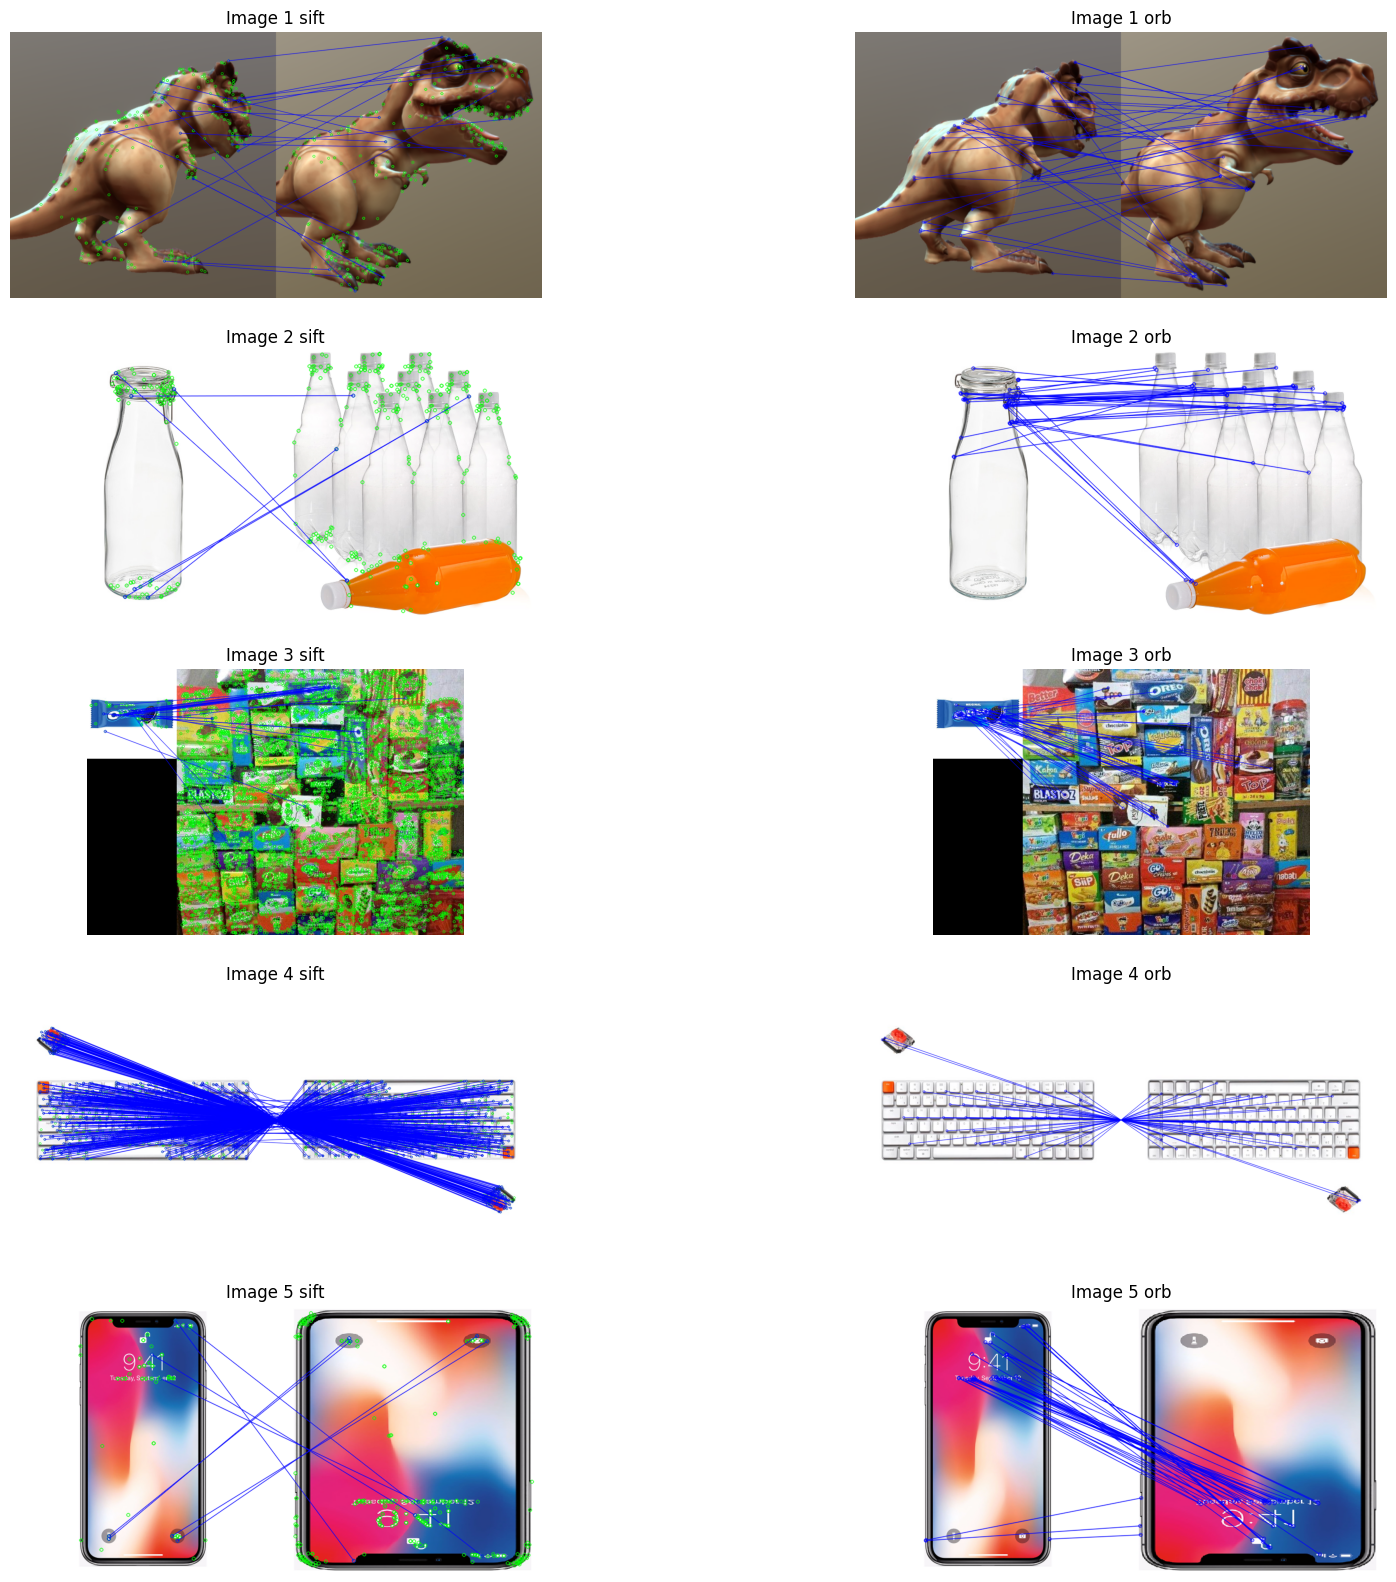

In [24]:
plt.figure(figsize=(20, 20))
for i, image in enumerate(image_results):
    plt.subplot(5, 2, i*2 + 1)
    plt.imshow(cv2.cvtColor(image['sift'], cv2.COLOR_BGR2RGB), cmap='gray')
    plt.axis('off')
    plt.title("Image {} sift".format(i+1))

    plt.subplot(5, 2,  i*2 + 2)
    plt.imshow(cv2.cvtColor(image['orb'], cv2.COLOR_BGR2RGB), cmap='gray')
    plt.axis('off')
    plt.title("Image {} orb".format(i+1))
plt.show()